<a href="https://colab.research.google.com/github/fosfrancesco/pitch-spelling/blob/main/rnncrf_pitch_spelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install --upgrade pytorch-crf

In [1]:
# from google.colab import files

import music21 as m21
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import pickle

from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn
import music21 as m21
from collections import Counter

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from torchcrf import CRF

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tqdm import tqdm, tqdm_notebook, notebook
import pickle

from sklearn.metrics import accuracy_score

import time

from collections import defaultdict, Counter
# import optuna

# RNN-CRF for Pitch Spelling

Dataset: different authors from ASAP collection
Challenges:
- extremely long sequences
- small dataset

In [2]:
pitches_dict = {
    0 : ["C","B#","D--"], # nn.Linear(input_size+context_size, 3)
    1 : ["C#","B##","D-"], # nn.Linear(input_size+context_size, 2)
    2 : ["D","C##","E--"], # nn.Linear(input_size+context_size, 3)
    3 : ["D#","E-","F--"],
    4 : ["E","D##","F-"],
    5 : ["F","E#","G--"],
    6 : ["F#","E##","G-"],
    7 : ["G","F##","A--"],
    8 : ["G#","A-"],
    9 : ["A","G##","B--"],
    10 : ["A#","B-","C--"],
    11 : ["B","A##","C-"]
}

accepted_pitches = [ii for i in pitches_dict.values() for ii in i]
print([e for e in enumerate(accepted_pitches)])

double_acc_pitches = [ii for i in pitches_dict.values() for ii in i if ii.endswith("##") or  ii.endswith("--") ]
print(double_acc_pitches)

def score2midi_numbers(score):
    return [p.midi%12 for n in score.flat.notes for p in n.pitches]

def score2pitches(score):
    return [p.name for n in score.flat.notes for p in n.pitches]

interval_dict = {
    0 : ["P1","d2","A7"], 
    1 : ["m2","A1"], 
    2 : ["M2","d3","AA1"], 
    3 : ["m3","A2"],
    4 : ["M3","d4","AA2"],
    5 : ["P4","A3"],
    6 : ["d5","A4"],
    7 : ["P5","d6","AA4"],
    8 : ["m6","A5"],
    9 : ["M6","d7","AA5"],
    10 : ["m7","A6"],
    11 : ["M7","d1","AA6"]
}

accepted_intervals = [ii for i in interval_dict.values() for ii in i]
print([e for e in enumerate(accepted_intervals)])

def transp_score(score):
    """ For each input return len(accepted_intervals) transposed scores"""
    return [score.transpose(interval) for interval in accepted_intervals]

def smart_transp_score(score):
    """ For each chromatic interval chose the interval that lead to the smallest number of accidentals"""
    scores = []
    for chromatic_int in interval_dict.keys():
        temp_scores = []
        temp_acc_number = []
        for diat_interval in interval_dict[chromatic_int]:
            new_score = score.transpose(diat_interval)
            temp_scores.append(new_score)
            temp_acc_number.append(sum([pitch.count("#") + pitch.count("-") for pitch in score2pitches(new_score)]))
            # print("choice:", [note.name for note in temp_scores[-1].flat.notes][0:10],"acc:",temp_acc_number[-1] )
        #keep only the one with the lowest number of accidentals
        min_index = np.argmin(temp_acc_number)
        # print("preferred the number", min_index)
        scores.append(temp_scores[min_index])
    return scores

def acc_simple_enough(score,accepted_ratio = 0.2 ):
    pitches = score2pitches(score)
    double_acc = sum(el in double_acc_pitches for el in pitches)
    if double_acc/len(pitches) < accepted_ratio:
        return True
    else:
        return False



diatonic_pitches = ["C","D", "E", "F", "G", "A", "B"]

# #test acc_simple_enough()
# score = m21.converter.parse(paths[356])
# scores = smart_transp_score(score)
# #delete the pieces with non accepted pitches (e.g. triple sharps)
# scores = [s for s in scores if all(pitch in accepted_pitches for pitch in score2pitches(s))]
# for s in scores:
#     print(s.parts[0].flat.getElementsByClass(m21.key.KeySignature)[0], "simple enough:", acc_simple_enough(s))
#     print([n.name for n in s.flat.notes])

[(0, 'C'), (1, 'B#'), (2, 'D--'), (3, 'C#'), (4, 'B##'), (5, 'D-'), (6, 'D'), (7, 'C##'), (8, 'E--'), (9, 'D#'), (10, 'E-'), (11, 'F--'), (12, 'E'), (13, 'D##'), (14, 'F-'), (15, 'F'), (16, 'E#'), (17, 'G--'), (18, 'F#'), (19, 'E##'), (20, 'G-'), (21, 'G'), (22, 'F##'), (23, 'A--'), (24, 'G#'), (25, 'A-'), (26, 'A'), (27, 'G##'), (28, 'B--'), (29, 'A#'), (30, 'B-'), (31, 'C--'), (32, 'B'), (33, 'A##'), (34, 'C-')]
['D--', 'B##', 'C##', 'E--', 'F--', 'D##', 'G--', 'E##', 'F##', 'A--', 'G##', 'B--', 'C--', 'A##']
[(0, 'P1'), (1, 'd2'), (2, 'A7'), (3, 'm2'), (4, 'A1'), (5, 'M2'), (6, 'd3'), (7, 'AA1'), (8, 'm3'), (9, 'A2'), (10, 'M3'), (11, 'd4'), (12, 'AA2'), (13, 'P4'), (14, 'A3'), (15, 'd5'), (16, 'A4'), (17, 'P5'), (18, 'd6'), (19, 'AA4'), (20, 'm6'), (21, 'A5'), (22, 'M6'), (23, 'd7'), (24, 'AA5'), (25, 'm7'), (26, 'A6'), (27, 'M7'), (28, 'd1'), (29, 'AA6')]


## Import ASAP dataset

In [3]:
# !git clone https://github.com/fosfrancesco/pitch-spelling.git

basepath = "./" #to change if running locally or on colab

In [4]:
# load the asap datasets
with open(Path(basepath,'datasets','baroque_aug_asap.pkl'), 'rb') as fid:
     dataset_baroque = pickle.load( fid)

with open(Path(basepath,'datasets','classical_aug_asap.pkl'), 'rb') as fid:
     dataset_classical = pickle.load( fid)

with open(Path(basepath,'datasets','romantic_aug_asap.pkl'), 'rb') as fid:
     dataset_romantic = pickle.load( fid)
        
# with open(Path(basepath,'datasets','remaining_aug_asap.pkl'), 'rb') as fid:
#      dataset_remaining = pickle.load( fid)

# merge the three files together
# full_dict_dataset = dataset_baroque + dataset_classical + dataset_romantic + dataset_remaining
full_dict_dataset = dataset_baroque + dataset_classical + dataset_romantic 

In [5]:
paths = list(set([e["original_path"] for e in full_dict_dataset ]))

# print(paths)
print(len(paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_dict_dataset ]))


191 different pieces
Average number of notes:  2219.6285387474977


## Chose the convenient data augmentation
Two possibilities:
- for each chromatic interval, take only the diatonic transposition that produce the smallest number of accidentals (or the original if present)
- take only a certain interval of time signatures

The second is probably better for a smaller and simple dataset, but gives the problem of chosing between for example F# and G# that are both present in this bigger dataset. So we go for the first criterion.

In [6]:
# choose only one enharmonic version for each chromatic interval for each piece
dict_dataset = []
for path in paths:
    for c in range(12):
        pieces_to_consider = [opus for opus in full_dict_dataset 
                              if (opus["original_path"] == path and opus["transposed_of"] in interval_dict[c])  ]
        # if the original is in pieces_to_consider, go with the original
        originals = [opus for opus in pieces_to_consider if opus["transposed_of"] == "P1"]
        if len(originals) == 1:
            dict_dataset.append(originals[0])
        else: #we go with the accidental minization criteria
            n_accidentals = [sum([pitch.count("#") + pitch.count("-") for pitch in opus["pitches"]]) 
                            for opus in pieces_to_consider]
            if len(pieces_to_consider)>0:
                dict_dataset.append(pieces_to_consider[np.argmin(n_accidentals)])
            else:
                print("No options for", path, ". Chromatic: ",c )

# accepted_ks = range(-5,6)
# dict_dataset = [e for e in full_dict_dataset if e["key_signature"] in accepted_ks]

#test if it worked
for i,e in enumerate(dict_dataset):
    print(e["original_path"], e["transposed_of"], e["key_signature"])
    print(e["pitches"][:10])
    print(e["midi_number"][:10])
    if i == 100:
        break

No options for Chopin/Etudes_op_25/10/xml_score.musicxml . Chromatic:  4
No options for Chopin/Etudes_op_25/10/xml_score.musicxml . Chromatic:  9
No options for Chopin/Etudes_op_10/4/xml_score.musicxml . Chromatic:  4
No options for Chopin/Etudes_op_10/4/xml_score.musicxml . Chromatic:  9
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  1
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  4
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  6
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  9
No options for Schubert/Wanderer_fantasie/xml_score.musicxml . Chromatic:  11
No options for Chopin/Sonata_2/1st_no_repeat/xml_score.musicxml . Chromatic:  1
No options for Chopin/Sonata_3/4th/xml_score.musicxml . Chromatic:  1
No options for Chopin/Sonata_3/4th/xml_score.musicxml . Chromatic:  3
No options for Chopin/Sonata_3/4th/xml_score.musicxml . Chromatic:  6
No options for Chopin/Sonata_3/4th

In [7]:
print(len(dict_dataset))

c = Counter()
for p in paths:
    c[p.split("/")[0]] +=1

print(c)

2271
Counter({'Bach': 59, 'Beethoven': 57, 'Chopin': 34, 'Schubert': 13, 'Haydn': 11, 'Schumann': 10, 'Mozart': 6, 'Brahms': 1})


In [8]:
# TODO: remove pieces from asap that are in Musedata
print(len(paths), "initial pieces")
paths = [p for p in paths if p!= "Bach/Prelude/bwv_865/xml_score.musicxml"]
print(len(paths), "pieces after removing overlapping with musedata")

191 initial pieces
190 pieces after removing overlapping with musedata


In [9]:
# Temporary remove composer with only one piece, because they create problems with sklearn stratify
one_piece_composers = ['Balakirev','Prokofiev','Brahms','Glinka']
paths = [p for p in paths if p.split("/")[0] not in one_piece_composers]

# Divide train and validation set
path_train, path_validation = sklearn.model_selection.train_test_split(paths, test_size=0.15,stratify=[p.split("/")[0] for p in paths ])
print("Train and validation lenghts: ",len(path_train),len(path_validation))

#Put back one piece composers in the validation dataset
# TODO

Train and validation lenghts:  160 29


['Haydn', 'Beethoven', 'Bach', 'Schumann', 'Chopin', 'Mozart', 'Schubert']


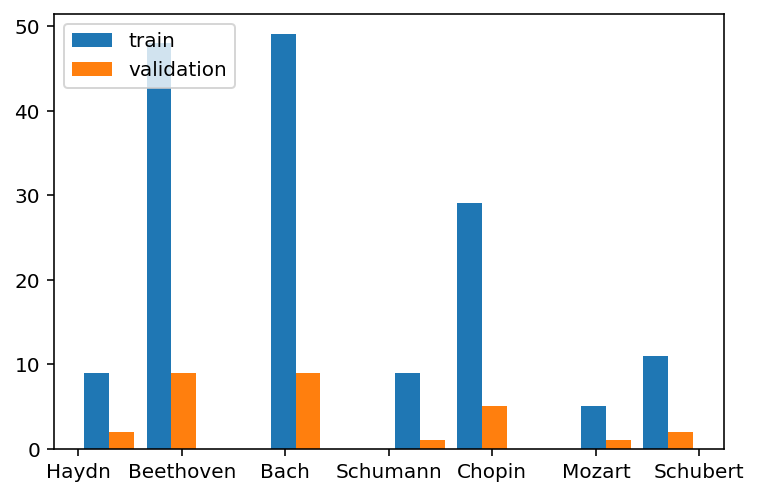

In [10]:
#need to find a better way to visualize this
composers = list(set([p.split("/")[0] for p in paths ]))
print(composers)

train_composer = [composers.index(p.split("/")[0]) for p in path_train]
val_composer = [composers.index(p.split("/")[0]) for p in path_validation]

_ = plt.hist([train_composer, val_composer], label=['train', 'validation'])
_ = plt.legend(loc='upper left')
_ = plt.xticks(list(range(len(composers))), composers)

## Transform the input into a convenient format for the Model

In [11]:
# Helper functions to feed the correct input into the NN 

PAD = "<PAD>"

tag_to_ix = {p: accepted_pitches.index(p) for p in accepted_pitches}
#add PADDING TAD
tag_to_ix[PAD] = len(accepted_pitches)

midi_to_ix = {m: m for m in range(12)}
# #add PADDING TAD
# midi_to_ix[PAD] = 12

# print(midi_to_ix[1])
# print(len(midi_to_ix))

duration_delimiter = [0.125,0.25,0.5,1,2,4]


class Pitch2Diatonic():
    def __call__(self, in_seq,weights = None):
        return [p for p in in_seq]

class Diatonic2Int():
    def __call__(self, in_seq,weights = None):
        idxs = [tag_to_ix[w] for w in in_seq]
        return idxs

class Int2Pitch():
    def __call__(self, in_seq):
        return [accepted_pitches[i] for i in in_seq]

class OneHotEncoder():
    def __init__(self, alphabet_len):
        self.alphabet_len = alphabet_len
        
    def __call__(self, sample,weights = None):
        onehot = np.zeros([len(sample), self.alphabet_len])
        tot_chars = len(sample)
        onehot[np.arange(tot_chars), sample] = 1
        return onehot

# class WeightedOneHotEncoder():
#     def __init__(self, alphabet_len):
#         self.alphabet_len = alphabet_len
        
#     def __call__(self, sample, weights=None):
#         if weights == None:
#             weights = np.ones(len(sample))
#         onehot = torch.nn.functional.one_hot(sample,self.alphabet_len)
#         return (onehot.t()*torch.Tensor(weights)).t() #transpositions to allow the broadcasting
    
class DurationOneHotEncoder():
    def __init__(self, pitch_alphabet_len, duration_delimiter):
        self.pitch_alphabet_len = pitch_alphabet_len
        self.dur_alphabet_len = len(duration_delimiter)+2
        self.duration_delimiter = duration_delimiter
        
    def __call__(self, sample, durs):
        sample = torch.tensor(sample,dtype=torch.long)
        onehot_pitch = torch.nn.functional.one_hot(sample,self.pitch_alphabet_len)
        quantized_durations = np.digitize(durs,self.duration_delimiter)
        quantized_durations = torch.tensor(quantized_durations,dtype=torch.long)
        onehot_duration = torch.nn.functional.one_hot(quantized_durations,self.dur_alphabet_len)
        return torch.cat([onehot_pitch,onehot_duration],1)
        
class ToTensorFloat():
    def __call__(self, sample, weight = None):
        if type(sample) is torch.Tensor:
            return sample.float()
        else:
            return torch.tensor(sample,dtype=torch.float)

class ToTensorLong():
    def __call__(self, sample, weights = None):
        if type(sample) is torch.Tensor:
            return sample.long()
        else:
            return torch.tensor(sample,dtype=torch.long)
    
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample, weights):
        for t in self.transforms:
            sample = t(sample, weights)
        return sample

pitches_len = len(accepted_pitches)
midinote_len = 12

### Define the preprocessing pipeline
transform_diat = Compose([Pitch2Diatonic(),Diatonic2Int(),ToTensorLong()])
transform_chrom = Compose([DurationOneHotEncoder(len(midi_to_ix),duration_delimiter),ToTensorFloat()])

In [12]:
a =[list(range(10)) for e in range(4)]
torch.Tensor(a).shape

torch.Size([4, 10])

In [13]:
# Create the dataset
# TODO: order sequences for better memory efficiency

class PSDataset(Dataset):
    def __init__(self, dict_dataset, paths, transf_c, transf_d, augment_dataset, sort =False, truncate = None):
        if sort:
            dict_dataset = sorted(dict_dataset, key = lambda e: (len(e['midi_number'])))
        if augment_dataset:
            self.chromatic_sequences = [e["midi_number"] for e in dict_dataset if e["original_path"] in paths]
            self.diatonic_sequences = [e["pitches"]
                                       for e in dict_dataset 
                                       if e["original_path"] in paths]
            self.durations = [e["duration"] for e in dict_dataset if e["original_path"] in paths]
        else: #consider only non transposed pieces
            self.chromatic_sequences = [e["midi_number"] for e in dict_dataset 
                                        if (e["original_path"] in paths and e["transposed_of"]=="P1")]
            self.diatonic_sequences = [e["pitches"]
                                       for e in dict_dataset 
                                       if (e["original_path"] in paths and e["transposed_of"]=="P1")]
            self.durations = [e["duration"] 
                              for e in dict_dataset 
                              if (e["original_path"] in paths and e["transposed_of"]=="P1")]
        #the transformations to apply to data
        self.transf_c = transf_c
        self.transf_d = transf_d
        self.truncate = truncate

    def __len__(self):
        return len(self.chromatic_sequences)

    def __getitem__(self, idx):
        chromatic_seq = self.chromatic_sequences[idx]
        diatonic_seq = self.diatonic_sequences[idx]
        duration_seq = self.durations[idx]
        weights = [dur/4  if dur<=4 else 1 for dur in duration_seq  ] # limit the weights to (0,4)       

        #transform
        chromatic_seq = self.transf_c(chromatic_seq,weights)
        diatonic_seq = self.transf_d(diatonic_seq,None)

        if not self.truncate is None:
            if len(diatonic_seq) > self.truncate:
                chromatic_seq = chromatic_seq[0:self.truncate]
                diatonic_seq = diatonic_seq[0:self.truncate]

        #sanity check
        assert len(chromatic_seq) == len(diatonic_seq)
        seq_len = len(diatonic_seq)
        
        return chromatic_seq, diatonic_seq, seq_len

train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,True)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat, False)

print(len(train_dataset),len(validation_dataset))



# test if it works
for chrom,diat,seq_len in train_dataset:
    print(chrom[0:30])
    print(torch.argmax(chrom[0:30],1))
    # print([diatonic_pitches[p.item()] for p in diat[0:30]])
    print([accepted_pitches[p.item()] for p in diat[0:30]])
    break

1900 29
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
  

In [14]:
def pad_collate(batch):
    (xx, yy, l) = zip(*batch)
    
    xx_pad = pad_sequence(xx)
    yy_pad = pad_sequence(yy, padding_value=tag_to_ix[PAD])

    #sort the sequences by length
    seq_lengths, perm_idx = torch.Tensor(l).sort(0, descending=True)
    xx_pad = xx_pad[:,perm_idx,:]
    yy_pad = yy_pad[:,perm_idx]

    return xx_pad, yy_pad, seq_lengths

# data_loader = DataLoader(dataset=validation_dataset, batch_size=4, shuffle=True, collate_fn=pad_collate)



# #test if it work
# for batch in data_loader:
#     print(batch[0].shape,batch[1].shape,batch[2])
#     print(batch[1])
#     break

## Model Definition

In [15]:
class RNNTagger(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, n_labels,n_layers =1):
        super(RNNTagger,self).__init__()    
        
        self.n_labels = n_labels
        self.hidden_dim = hidden_dim

        # RNN layer. We're using a bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer = nn.Linear(hidden_dim, self.n_labels)
    
        # Loss function that we will use during training.
        self.loss = torch.nn.CrossEntropyLoss(reduction='sum',ignore_index = tag_to_ix[PAD])
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)

        out = self.top_layer(rnn_out)
       
        # # Find the positions where the token is a dummy padding token.
        # pad_mask = (sentences == self.pad_word_id).float()

        # # For these positions, we add some large number in the column corresponding
        # # to the dummy padding label.
        # out[:, :, self.pad_label_id] += pad_mask*10000

        return out
                
    def forward(self, sentences, labels, sentences_len):
        # First computes the predictions, and then the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
            
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)
        return self.loss(scores, labels)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted = scores.argmax(dim=2)

        return [predicted[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]

In [16]:
class RNNCRFTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_labels,n_layers =1):
        super(RNNCRFTagger,self).__init__()    
        
        self.n_labels = n_labels
        self.hidden_dim = hidden_dim

        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)

        self.top_layer = nn.Linear(hidden_dim, self.n_labels)
    
        self.crf = CRF(self.n_labels)
        
    def compute_outputs(self, sentences,sentences_len):
        ## should I initialize here??
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)

        out = self.top_layer(rnn_out)
      
        return out
                
    def forward(self, sentences, labels, sentences_len):
        # Compute the outputs of the lower layers, which will be used as emission
        # scores for the CRF.
        scores = self.compute_outputs(sentences,sentences_len)

        # We return the loss value. The CRF returns the log likelihood, but we return 
        # the *negative* log likelihood as the loss value.            
        # PyTorch's optimizers *minimize* the loss, while we want to *maximize* the
        # log likelihood.

        pad_mask = torch.arange(max(sentences_len))[:, None] < sentences_len[None, :]
        pad_mask = pad_mask.byte().to(device)
        return -self.crf(scores, labels, mask = pad_mask )
            
    def predict(self, sentences,sentences_len):
        # Compute the emission scores, as above.
        scores = self.compute_outputs(sentences,sentences_len)

        # Apply the Viterbi algorithm to get the predictions. This implementation returns
        # the result as a list of lists (not a tensor), corresponding to a matrix
        # of shape (n_sentences, max_len).
        pad_mask = torch.arange(max(sentences_len))[:, None] < sentences_len[None, :]
        pad_mask = pad_mask.byte().to(device)
        return self.crf.decode(scores,mask = pad_mask)

In [15]:
class RNNAttentionTagger(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, n_labels,n_layers =1):
        super(RNNAttentionTagger,self).__init__()    
        
        self.n_labels = n_labels
        self.hidden_dim = hidden_dim

        # RNN layer. We're using a bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer = nn.Linear(hidden_dim, self.n_labels)
    
        # Loss function that we will use during training.
        self.loss = torch.nn.CrossEntropyLoss(reduction='sum',ignore_index = tag_to_ix[PAD])
        
        # attention function
        # TODO : set right parameters
        self.attention = Attention(hidden_dim)
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)
        # use attention
        attn_applied = self.attention(rnn_out,rnn_out,sentences_len)
        
        out = self.top_layer(attn_applied) #maybe remove this one?
        return out
                
    def forward(self, sentences, labels, sentences_len):
        # First computes the predictions, and then the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
            
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)
        return self.loss(scores, labels)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted = scores.argmax(dim=2)

        return [predicted[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]
    
    
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention,self).__init__()

        self.hidden_dim = hidden_dim
        self.W = torch.nn.Parameter(torch.FloatTensor(
            hidden_dim, hidden_dim).uniform_(-0.1, 0.1))

    def forward(self,
                query, # [seq_len, batch, hidden_dim]
                values, # [seq_len, batch, hidden_dim]
                sentences_len
               ):
        weights = self._get_weights(query, values) # [batch,seq_length,hidden_dim]
        
        weights = torch.nn.functional.softmax(weights, dim=2)
        # mask the weights
        inverted_pad_mask = torch.arange(max(sentences_len))[None,:] > sentences_len[:,None]
        inverted_pad_mask = (inverted_pad_mask.float()*(-10000))[:,:,None].to(device)
#         print(weights.shape,inverted_pad_mask.shape )
        #apply the mast
        weights = weights - inverted_pad_mask
        out = torch.transpose((weights @ torch.transpose(values,0,1)),0,1)
#         print("ATT out shape", out.shape)
        return out # [seq_len,batch,encoder_dim]

    def _get_weights(self,
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
    ):
        #transpose to batch first to correctly handle batch multiplications
#         print("shape",query.shape,self.W.shape, values.shape)
        query,values = torch.transpose(query,0,1),torch.transpose(values,0,1)
#         print("shape",query.shape,self.W.shape, values.shape)
#         print("stape values.t", torch.transpose(values,1,2).shape)
        weights = query @ self.W @ torch.transpose(values,1,2)  # [seq_length]
#         print("out att shape", weights.shape)
        return weights/np.sqrt(self.hidden_dim)  # [seq_length]

In [16]:
class RNNMultAttentionTagger(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, n_labels,n_layers =1):
        super(RNNMultAttentionTagger,self).__init__()    
        
        self.n_labels = n_labels
        self.hidden_dim = hidden_dim

        # RNN layer. We're using a bidirectional GRU
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)
        
        # Output layer. The input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer = nn.Linear(hidden_dim, self.n_labels)
    
        # Loss function that we will use during training.
        self.loss = torch.nn.CrossEntropyLoss(reduction='sum',ignore_index = tag_to_ix[PAD])
        
        # attention function
        # TODO : set right parameters
        self.attention = torch.nn.MultiheadAttention(hidden_dim,num_heads= 1)
        
    def compute_outputs(self, sentences,sentences_len):
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)
        # compute padding mask (True when padded, ignore True)
        inverted_pad_mask = torch.arange(max(sentences_len))[None,:] > sentences_len[:,None]
        
        # use attention
        attn_applied, _ = self.attention(rnn_out,rnn_out,rnn_out,key_padding_mask = inverted_pad_mask.to(device))
        
        out = self.top_layer(attn_applied) #maybe remove this one?
        return out
                
    def forward(self, sentences, labels, sentences_len):
        # First computes the predictions, and then the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores = self.compute_outputs(sentences,sentences_len)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
            
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)
        return self.loss(scores, labels)

    def predict(self, sentences,sentences_len):
        # Compute the outputs from the linear units.
        scores = self.compute_outputs(sentences,sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted = scores.argmax(dim=2)

        return [predicted[:int(l),i].cpu().numpy() for i,l in enumerate(sentences_len)]

## Train model

In [17]:
# TODO: search over the best hyperparameters

In [18]:
def training_loop(model, optimizer, train_dataloader, val_dataloader, n_epochs):
    history = defaultdict(list)  
    for i_epoch in range(1,n_epochs +1):
        t0 = time.time()
        loss_sum = 0
        accuracy_sum = 0
        model.train()
        for seqs, targets, lens in train_dataloader: #seqs, targets, lens are batches
            seqs, targets = seqs.to(device), targets.to(device)
            optimizer.zero_grad()
#             print("input seq shape:",seqs.shape)

            loss = model(seqs,targets,lens) / sum(lens) #normalize for the number of symbol considered (without padding)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

            predicted = model.predict(seqs,lens)
            for i,p in enumerate(predicted):
                acc= accuracy_score(p,targets[:,i][:len(p)].cpu()) #compute the accuracy without considering the padding
                accuracy_sum += acc/len(lens) #normalize according to the number of sequences in the batch

        train_loss = loss_sum/len(train_dataloader)
        train_accuracy = accuracy_sum/len(train_dataloader) #normalize according to the number of batches
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)


        # Evaluate on the validation set
        model.eval()
        all_predicted = []
        all_targets = []
        with torch.no_grad():
            for seqs,targets, lens in val_dataloader:
                # Predict the model's output on a batch
                predicted = model.predict(seqs.to(device),lens)                   
                # Update the lists that will be used to compute the accuracy
                for i,p in enumerate(predicted):
                    all_predicted.append(torch.Tensor(p))
                    all_targets.append(targets[0:int(lens[i]),i])
                
        # Compute the overall accuracy for the validation set
        val_accuracy = accuracy_score(torch.cat(all_predicted),torch.cat(all_targets))
        history["val_accuracy"].append(val_accuracy)

#         save the model
        torch.save(model, "./models/temp/model_temp_epoch{}.pkl".format(i_epoch))
#         files.download("model_temp_epoch{}.pkl".format(i_epoch))

    
        t1 = time.time()
        print(f'Epoch {i_epoch}: train loss = {train_loss:.4f}, train_accuracy: {train_accuracy:.4f},val_accuracy: {val_accuracy:.4f}, time = {t1-t0:.4f}')
    return history

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

n_epochs = 20
HIDDEN_DIM = 96
LEARNING_WEIGHT = 0.05
WEIGHT_DECAY = 0 #1e-4
BATCH_SIZE = 2
MOMENTUM = 0.9

train_dataset = PSDataset(dict_dataset,path_train, transform_chrom,transform_diat,True,sort=True, truncate = None)
validation_dataset = PSDataset(dict_dataset,path_validation, transform_chrom,transform_diat, False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=pad_collate)
val_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False,collate_fn=pad_collate)

# model = torch.load("./models/temp/model_temp_epoch30-to_restart.pkl")
# model = RNNCRFTagger(len(midi_to_ix)+len(duration_delimiter)+2,HIDDEN_DIM,len(tag_to_ix), n_layers =1)
model = RNNMultAttentionTagger(len(midi_to_ix)+len(duration_delimiter)+2,HIDDEN_DIM,len(tag_to_ix), n_layers =1)
model = model.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_WEIGHT)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_WEIGHT, momentum = MOMENTUM,weight_decay=WEIGHT_DECAY)
# otimizer = torch.optim.Adam(model.parameters(),lr = 0.05, weight_decay=1e-4)

history = training_loop(model,optimizer,train_dataloader,val_dataloader, n_epochs)

# After the final evaluation, we print more detailed evaluation statistics,
plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy'])

Training device: cuda
Epoch 1: train loss = 2.1270, train_accuracy: 0.3498,val_accuracy: 0.8941, time = 146.1986
Epoch 2: train loss = 0.4894, train_accuracy: 0.8669,val_accuracy: 0.9160, time = 146.6378
Epoch 3: train loss = 0.3586, train_accuracy: 0.8902,val_accuracy: 0.9312, time = 146.2931
Epoch 4: train loss = 0.3192, train_accuracy: 0.9039,val_accuracy: 0.9380, time = 145.7303
Epoch 5: train loss = 0.3018, train_accuracy: 0.9111,val_accuracy: 0.9247, time = 146.5489


In [22]:
#find the best working model on the accuracy
max_accuracy = np.max(history['val_accuracy'])
best_epoch = np.argmax(history['val_accuracy'])
print("Best validation accuracy: ",max_accuracy, "at epoch",best_epoch)

plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy'])

NameError: name 'history' is not defined

In [ ]:
# torch.save(model, "./models/model_asap_crf200dur.pkl")
# files.download("model_asap_crf300.pkl")

### print attention

## Test on Mdata dataset

In [5]:
model = torch.load("./models/best_multiAttn_acc9730.pkl")

In [8]:
# load the dataset
with open(Path(basepath,'./datasets/aug_musedata.pkl'), 'rb') as fid:
     full_mdata_dict_dataset = pickle.load( fid)

In [9]:
mdata_paths = list(set([e["original_path"] for e in full_mdata_dict_dataset ]))

# # remove the symbphony No.100 from Haydn because of the enharmonic transposition
# paths.remove("datasets\\opnd\\haydndoversyms-10004m.opnd-m")

# print(paths)
print(len(mdata_paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_mdata_dict_dataset ]))

216 different pieces
Average number of notes:  858.6319771007974


In [18]:
mdata_dataset = PSDataset(full_mdata_dict_dataset,mdata_paths, transform_chrom,transform_diat,False)
mdata_dataloader  = DataLoader(mdata_dataset,  batch_size=16, shuffle=False, collate_fn=pad_collate)

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

all_inputs = []
all_outputs = []
all_targets = []
model.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for seqs, targets,lens in mdata_dataloader:
        # Move data to device
        seqs = seqs.to(device)

        # Predict the model's output on a batch.
        predicted = model.predict(seqs,lens)                   
        # Update the evaluation statistics.
        for i,p in enumerate(predicted):
            all_inputs.append(torch.argmax(seqs[0:int(lens[i]),i,:].cpu(),1).numpy())
            all_outputs.append(torch.Tensor(p))
            all_targets.append(targets[0:int(lens[i]),i])

Using device: cuda


RuntimeError: sub_iter.strides(0)[0] == 0 INTERNAL ASSERT FAILED at "/pytorch/aten/src/ATen/native/cuda/Reduce.cuh":928, please report a bug to PyTorch. 

In [ ]:
# Divide accuracy according to author
authors = []

for sequence in all_inputs:
    author = [e["original_path"].split("\\")[-1][:3] for e in full_mdata_dict_dataset
              if len(e["midi_number"]) == len(sequence) and
              list(e["midi_number"]) ==list(sequence) ]
    # assert len(author) == 1
    authors.append(author[0])

considered_authors = list(set(authors))
print(considered_authors)

In [28]:
errors_per_author = {}
accuracy_per_author = {}
notes_per_author = {}
for ca in considered_authors:
    # ca_inputs = torch.cat([all_inputs[i] for i,a in enumerate(authors) if a == ca])
    ca_outputs = torch.cat([all_outputs[i] for i,a in enumerate(authors) if a == ca])
    ca_targets = torch.cat([all_targets[i] for i,a in enumerate(authors) if a == ca])
    # print(ca_inputs.shape,ca_outputs.shape,ca_targets.shape,ca_predicted_pitches.shape)
    ca_acc = accuracy_score(ca_outputs,ca_targets)
    accuracy_per_author[ca] = float(ca_acc)
    errors_per_author[ca] = int(len(ca_targets) - sum(torch.eq(ca_outputs,ca_targets)))
    notes_per_author[ca] = len(ca_targets)

print(errors_per_author)
print(accuracy_per_author)
print(notes_per_author)
print("Total errors :", sum([e for e in errors_per_author.values()]))

NameError: name 'considered_authors' is not defined

### Best accuracy for now
for now best accuracy is with  no CRF (but considering durations) n_epochs = 20
HIDDEN_DIM = 96
LEARNING_WEIGHT = 0.09
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 16

duration_delimiter = [0.125,0.25,0.5,1,2,4]

Model available in: "model_temp_epoch12-noCRFacc9575.pkl"
accuracy on validation set 0.9575
Trained on all dataset


{'moz': 98, 'tel': 116, 'bac': 93, 'hay': 200, 'cor': 25, 'bee': 127, 'viv': 45, 'han': 52}
{'moz': 0.9959990201682044, 'tel': 0.995265306122449, 'bac': 0.9962048561518058, 'hay': 0.9918334013883218, 'cor': 0.9989793002082228, 'bee': 0.9948148450577716, 'viv': 0.9981630403722905, 'han': 0.9978775510204082}
{'moz': 24494, 'tel': 24500, 'bac': 24505, 'hay': 24490, 'cor': 24493, 'bee': 24493, 'viv': 24497, 'han': 24500}
Total errors : 756

This win by far against ps13

### Best accuracy with CRF
n_epochs = 20
HIDDEN_DIM = 96
LEARNING_WEIGHT = 1
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 16

model = RNNCRFTagger(len(midi_to_ix)+len(duration_delimiter)+2,HIDDEN_DIM,len(tag_to_ix), n_layers =1)

Model available in: ""./models/model_temp_CRFacc9548.pkl""
accuracy on validation set 0.9548586557910835
Trained on all asap dataset

{'viv': 36, 'tel': 41, 'bee': 185, 'bac': 101, 'han': 44, 'cor': 14, 'moz': 131, 'hay': 376}
{'viv': 0.9985304322978323, 'tel': 0.9983265306122449, 'bee': 0.9924468215408484, 'bac': 0.9958783921648643, 'han': 0.9982040816326531, 'cor': 0.9994284081166047, 'moz': 0.9946517514493345, 'hay': 0.9846467946100449}
{'viv': 24497, 'tel': 24500, 'bee': 24493, 'bac': 24505, 'han': 24500, 'cor': 24493, 'moz': 24494, 'hay': 24490}
Total errors : 928

Still win against ps13